In [7]:
!pip install segmentation-models-pytorch albumentations grad-cam gdown

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

import matplotlib.pyplot as plt

from PIL import Image

import gdown

import re

import shutil

import cv2

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils as smp_utils

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image


from zipfile import ZipFile

## Data Setup

In [19]:
# Unzip Dataset
data_folder = "ISVC_Segmentation"
DATA = "/home/datascience/ISVC_2023_Tutorial_XAI_Few_Shot_on_the_Cloud/SampleDataset(s)/"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SAVE_DIR = "checkpoints/"
SHOT = 10

In [20]:
if not os.path.exists(os.path.join(DATA, data_folder)):
    with ZipFile(f"{DATA}/{data_folder}.zip", 'r') as zipf:
        zipf.extractall(f"{DATA}")

In [21]:
from sklearn.model_selection import train_test_split
def generate_datasets(root_dir, image_dir, annot_dir,  task="localization"):
    img_dir = os.path.join(root_dir, image_dir)
    annot_dir = os.path.join(root_dir, annot_dir)
    
    # PID regex
    pid_reg = re.compile("9[0-9]{6}")
    
    # Image names + annotation names match
    records = [[pid_reg.findall(img)[-1], img, img if task != "localization" else img.replace(".jpg", ".xml")] 
               for img in os.listdir(img_dir) if ".DS_Store" not in img and ".ipynb_checkpoints" not in img]

    data_records = pd.DataFrame(records, columns=["pid", "images", "masks"])

    train, test = train_test_split(data_records.pid.unique(), test_size=0.5, random_state=42)
    valid, test = train_test_split(test, test_size=0.5, random_state=42)

    train = data_records[data_records.pid.isin(train)].reset_index(drop=True)
    valid = data_records[data_records.pid.isin(valid)].reset_index(drop=True)
    test = data_records[data_records.pid.isin(test)].reset_index(drop=True)

    return train, valid, test

In [22]:
train, valid, test = generate_datasets(f"{DATA}/{data_folder}", "Images", "Labels", task="segmentation")

In [23]:
train

,pid,images,masks
0,9988891,9988891R.png,9988891R.png
1,9975778,9975778R.png,9975778R.png
2,9999510,9999510L.png,9999510L.png
3,9975778,9975778L.png,9975778L.png
4,9993261,9993261L.png,9993261L.png
5,9978813,9978813L.png,9978813L.png
6,9996345,9996345R.png,9996345R.png
7,9989700,9989700R.png,9989700R.png
8,9989700,9989700L.png,9989700L.png
9,9983798,9983798R.png,9983798R.png


In [24]:
def get_few_shot_sample(dataset, k=1, random_state=42):
    if k > len(dataset):
        return dataset

    return dataset.sample(k, random_state=random_state).reset_index(drop=True)

In [25]:
train_few = get_few_shot_sample(train, k=SHOT)
valid_few = get_few_shot_sample(valid, k=SHOT)

In [26]:
few_shot_dir = "/home/datascience/ISVC_2023_Tutorial_XAI_Few_Shot_on_the_Cloud/SampleDataset(s)/Few_Shot/Segmentation"
shot = 10
if not os.path.exists(few_shot_dir):
    os.makedirs(few_shot_dir)

In [45]:
os.makedirs(f"{few_shot_dir}/{SHOT}-shot/train/images")
os.makedirs(f"{few_shot_dir}/{SHOT}-shot/train/labels")

os.makedirs(f"{few_shot_dir}/{SHOT}-shot/valid/images")
os.makedirs(f"{few_shot_dir}/{SHOT}-shot/valid/labels")

os.makedirs(f"{few_shot_dir}/{SHOT}-shot/test/images")
os.makedirs(f"{few_shot_dir}/{SHOT}-shot/test/labels")


FileExistsError: [Errno 17] File exists: '/home/datascience/ISVC_2023_Tutorial_XAI_Few_Shot_on_the_Cloud/SampleDataset(s)/Few_Shot/Segmentation/10-shot/train/images'

In [28]:
for pid in train_few.images:
    shutil.copy(f"{DATA}/{data_folder}/Images/{pid}", f"{few_shot_dir}/{SHOT}-shot/train/images/{pid}")
    shutil.copy(f"{DATA}/{data_folder}/Annotations/{pid}", f"{few_shot_dir}/{SHOT}-shot/train/labels/{pid}")

In [29]:
for pid in valid_few.images:
    shutil.copy(f"{DATA}/{data_folder}/Images/{pid}", f"{few_shot_dir}/{SHOT}-shot/valid/images/{pid}")
    shutil.copy(f"{DATA}/{data_folder}/Annotations/{pid}", f"{few_shot_dir}/{SHOT}-shot/valid/labels/{pid}")

In [30]:
for pid in test.images:
    shutil.copy(f"{DATA}/{data_folder}/Images/{pid}", f"{few_shot_dir}/{SHOT}-shot/test/images/{pid}")
    shutil.copy(f"{DATA}/{data_folder}/Annotations/{pid}", f"{few_shot_dir}/{SHOT}-shot/test/labels/{pid}")

In [31]:
class JointSpaceSegmentationDataset(Dataset):
    def __init__(self, img_root, mask_root, image_files, mask_files, transforms=None, preprocessing=None):
        self.img_root = img_root
        self.mask_root = mask_root
        self.img_files = image_files
        self.mask_files = mask_files
        self.transforms = transforms
        self.preprocessing = preprocessing

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        image = np.array(Image.open(os.path.join(self.img_root, self.img_files[idx])))
        mask = np.array(Image.open(os.path.join(self.mask_root, self.mask_files[idx])))


        if self.transforms is not None:
            transformed = self.transforms(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
        mask = torch.unsqueeze(mask, 0)
        if self.preprocessing is not None:
            transformed = self.preprocessing(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]

        return image.type(torch.FloatTensor), mask/255.0

In [32]:
FEW_SHOT_ROOT = f"{few_shot_dir}/{shot}-shot/"
train_augmentations = A.Compose([A.Resize(256, 256), A.Rotate(15), A.RandomBrightness(0.2),
                                 A.RandomContrast(0.2),  ToTensorV2()])

test_augmentations = A.Compose([A.Resize(256, 256), ToTensorV2()])

train_set = JointSpaceSegmentationDataset(os.path.join(FEW_SHOT_ROOT, "train/images"),
                                          os.path.join(FEW_SHOT_ROOT, "train/labels"),
                                          train_few.images, train_few.masks,
                                          preprocessing=None,#get_preprocessing(preprocessing_fn),
                                          transforms=train_augmentations)

valid_set = JointSpaceSegmentationDataset(os.path.join(FEW_SHOT_ROOT, "valid/images"),
                                          os.path.join(FEW_SHOT_ROOT, "valid/labels"),
                                          valid_few.images, valid_few.masks,
                                          preprocessing=None,#get_preprocessing(preprocessing_fn),
                                          transforms=test_augmentations)

test_set = JointSpaceSegmentationDataset(os.path.join(FEW_SHOT_ROOT, "test/images"),
                                         os.path.join(FEW_SHOT_ROOT, "test/labels"),
                                         test.images, test.masks,
                                         preprocessing=None,#get_preprocessing(preprocessing_fn),
                                         transforms=test_augmentations)
     

/home/datascience/conda/pytorch110_p38_gpu_v1/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/home/datascience/conda/pytorch110_p38_gpu_v1/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1284: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


In [33]:
if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

## Sample Augmentations

In [46]:
## Data Augmentations
img_pth = "/home/datascience/ISVC_2023_Tutorial_XAI_Few_Shot_on_the_Cloud/SampleDataset(s)/ISVC_Segmentation/Images/9975485L.png"
mask_pth = "/home/datascience/ISVC_2023_Tutorial_XAI_Few_Shot_on_the_Cloud/SampleDataset(s)/ISVC_Segmentation/Annotations/9975485L.png"

In [47]:
img = cv2.imread(img_pth)
mask = cv2.imread(mask_pth)

augA = A.Rotate(35)
augB = A.RandomBrightness(0.4)
augC = A.RandomContrast(0.4)

augA_out = augA(image=img, mask=mask, prob=1)
augB_out = augB(image=img, mask=mask, prob=1)
augC_out = augC(image=img, mask=mask, prob=1)

Text(0.5, 1.0, 'Mask')

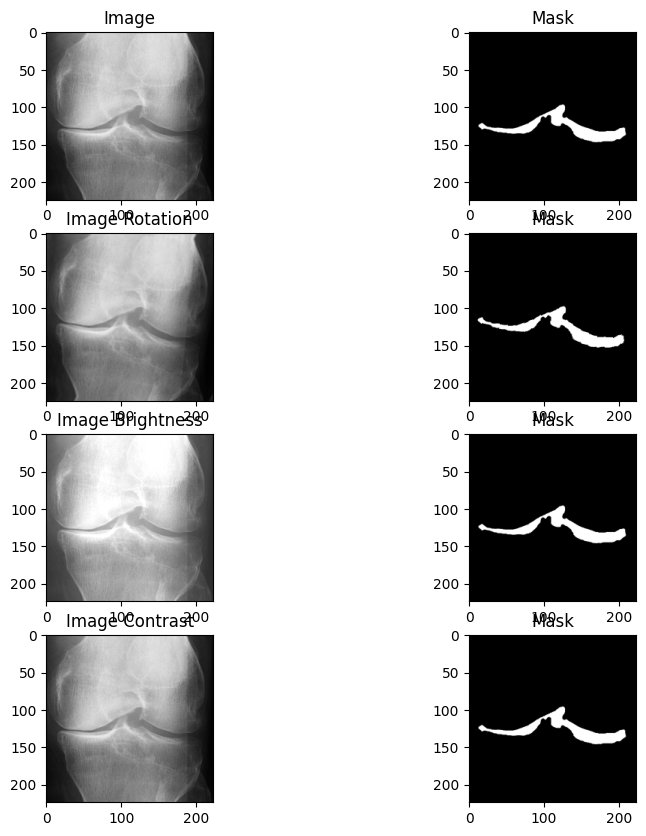

In [48]:
fig, axs = plt.subplots(4, 2, figsize=(10, 10))
axs[0, 0].imshow(img)
axs[0, 1].imshow(mask)
axs[0, 0].set_title("Image")
axs[0, 1].set_title("Mask")
axs[1, 0].imshow(augA_out["image"])
axs[1, 1].imshow(augA_out["mask"])
axs[1, 0].set_title("Image Rotation")
axs[1, 1].set_title("Mask")
axs[2, 0].imshow(augB_out["image"])
axs[2, 1].imshow(augB_out["mask"])
axs[2, 0].set_title("Image Brightness")
axs[2, 1].set_title("Mask")
axs[3, 0].imshow(augC_out["image"])
axs[3, 1].imshow(augC_out["mask"])
axs[3, 0].set_title("Image Contrast")
axs[3, 1].set_title("Mask")

## Model Training

In [40]:

encoder = "resnet18"
encoder_weights = "imagenet"
activation = "sigmoid"
num_classes = 1 # 0=background, 1=joint space

In [41]:
import copy
model = copy.deepcopy(smp.Unet(encoder_name=encoder, encoder_weights=encoder_weights, in_channels=1,
                 classes=num_classes, activation=activation))
model.encoder.requires_grad_ = True
model = model.to(DEVICE)
loss = nn.BCELoss()
loss.__name__="loss"
metrics = [smp_utils.metrics.IoU(threshold=0.5, activation=None), smp_utils.metrics.Fscore(0.5, activation=None)]
optimizer = torch.optim.Adam(model.parameters(), lr=5e-04)

In [42]:
train_loader = DataLoader(train_set, batch_size=2, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_set, batch_size=2, shuffle=False, num_workers=2)


In [43]:
# create epoch runners
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

In [44]:
# train model for 40 epochs

max_score = 0

for i in range(1, 101):

    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)

    # do something (save model, change lr, etc.)
    if max_score < valid_logs['fscore']:
        max_score = valid_logs['fscore']
        torch.save(model, f'{SAVE_DIR}/best_model_{SHOT}_shot.pth')
        print('Model saved!')


Epoch: 1
valid: 100%|██████████| 5/5 [00:00<00:00,  7.12it/s, loss - 0.3867, iou_score - 0.02787, fscore - 0.05697]
Model saved!

Epoch: 2
valid: 100%|██████████| 5/5 [00:00<00:00,  6.47it/s, loss - 0.4151, iou_score - 0.1313, fscore - 0.1815]
Model saved!

Epoch: 3
valid: 100%|██████████| 5/5 [00:00<00:00,  6.68it/s, loss - 1.609, iou_score - 0.1499, fscore - 0.1916]
Model saved!

Epoch: 4
valid: 100%|██████████| 5/5 [00:00<00:00,  6.78it/s, loss - 0.9822, iou_score - 0.2097, fscore - 0.25] 
Model saved!

Epoch: 5
valid: 100%|██████████| 5/5 [00:00<00:00,  6.44it/s, loss - 0.4174, iou_score - 0.4872, fscore - 0.5537]
Model saved!

Epoch: 6
valid: 100%|██████████| 5/5 [00:00<00:00,  6.29it/s, loss - 0.2212, iou_score - 0.7324, fscore - 0.8213]
Model saved!

Epoch: 7
valid: 100%|██████████| 5/5 [00:00<00:00,  6.61it/s, loss - 0.2227, iou_score - 0.717, fscore - 0.7727] 

Epoch: 8
valid: 100%|██████████| 5/5 [00:00<00:00,  6.69it/s, loss - 0.1721, iou_score - 0.7782, fscore - 0.8529]
Mo

## Model Testing

In [49]:
test_loader = DataLoader(test_set, batch_size=1, shuffle=False, num_workers=2)
test_img, test_mask  = next(iter(test_loader))

In [74]:
model = torch.load(f'{SAVE_DIR}/best_model_{SHOT}_shot.pth', map_location=torch.device(DEVICE))

avg_iou = 0.0
avg_fscore = 0.0
iou_metric = smp.utils.metrics.IoU(threshold=0.5)
fscore_metric = smp.utils.metrics.Fscore(threshold=0.5)
for img, mask in test_loader:
    out = model(img.to(DEVICE))
    mask = mask.to(DEVICE)
    avg_iou += iou_metric(out, mask).item()
    avg_fscore += fscore_metric(out, mask).item()

print(f"Test IoU: {avg_iou/len(test_loader)}\nTest Dice Score: {avg_fscore/len(test_loader)}")

Test IoU: 0.848328173160553
Test Dice Score: 0.9160128116607666


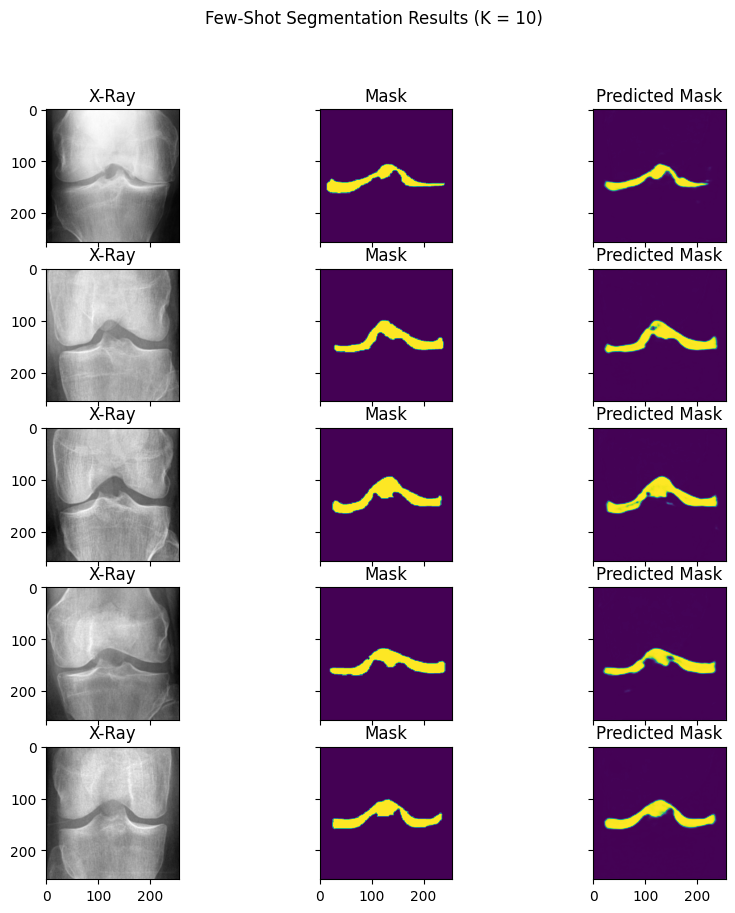

In [52]:
fig, ax = plt.subplots(5, 3, figsize=(10, 10), sharex=True, sharey=True)
fig.suptitle(f"Few-Shot Segmentation Results (K = {SHOT})")
for i, (img, mask) in enumerate(test_loader):
    ax[i, 0].imshow(img[0][0,:,:].squeeze(),cmap="gray")
    ax[i, 0].set_title("X-Ray")
    ax[i, 1].imshow(mask.squeeze())
    ax[i, 1].set_title("Mask")
    ax[i, 2].imshow(torch.sigmoid(model(img.to(DEVICE)).squeeze().detach().cpu()).numpy())
    ax[i, 2].set_title("Predicted Mask")

    if (i + 1) == 5:
        break

## Comparing Different K-Shot Values

In [53]:
gdown.download(id="1Tb3uhEfukPaFgc6KiKOpTUrpQAS1YkN8", output="./")

Downloading...
From (uriginal): https://drive.google.com/uc?id=1Tb3uhEfukPaFgc6KiKOpTUrpQAS1YkN8
From (redirected): https://drive.google.com/uc?id=1Tb3uhEfukPaFgc6KiKOpTUrpQAS1YkN8&confirm=t&uuid=63a9ae95-39ed-4a51-b8d6-fabf4bf84e30
To: /home/datascience/ISVC_2023_Tutorial_XAI_Few_Shot_on_the_Cloud/Code/Segmentation/checkpoints.zip
100%|██████████| 266M/266M [00:01<00:00, 170MB/s]  


'./checkpoints.zip'

In [54]:
!unzip checkpoints.zip

Archive:  checkpoints.zip
  inflating: __MACOSX/._checkpoints  
  inflating: checkpoints/best_model_1_shot.pth  
  inflating: __MACOSX/checkpoints/._best_model_1_shot.pth  
  inflating: checkpoints/best_model_7_shot.pth  
  inflating: __MACOSX/checkpoints/._best_model_7_shot.pth  
  inflating: checkpoints/best_model_3_shot.pth  
  inflating: __MACOSX/checkpoints/._best_model_3_shot.pth  
  inflating: checkpoints/best_model_5_shot.pth  
  inflating: __MACOSX/checkpoints/._best_model_5_shot.pth  
replace checkpoints/best_model_10_shot.pth? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [61]:
few_iou = []
few_dice = []

for shot in [1, 3, 5, 7, 10]:
    generate_datasets(f"{DATA}/{data_folder}", "Images", "Labels", task="segmentation")
    test_loader = DataLoader(test_set, batch_size=1, shuffle=False, num_workers=2)

    model = torch.load(f'{SAVE_DIR}/best_model_{shot}_shot.pth', map_location=torch.device(DEVICE))
    model = model.to(DEVICE)


    avg_iou = 0.0
    avg_fscore = 0.0
    iou_metric = smp.utils.metrics.IoU(threshold=0.5)
    fscore_metric = smp.utils.metrics.Fscore(threshold=0.5)
    for img, mask in test_loader:
        out = model(img.to(DEVICE))
        mask = mask.to(DEVICE)
        avg_iou += iou_metric(out, mask).item()
        avg_fscore += fscore_metric(out, mask).item()
    few_iou.append(avg_iou/len(test_loader))
    few_dice.append(avg_fscore/len(test_loader))

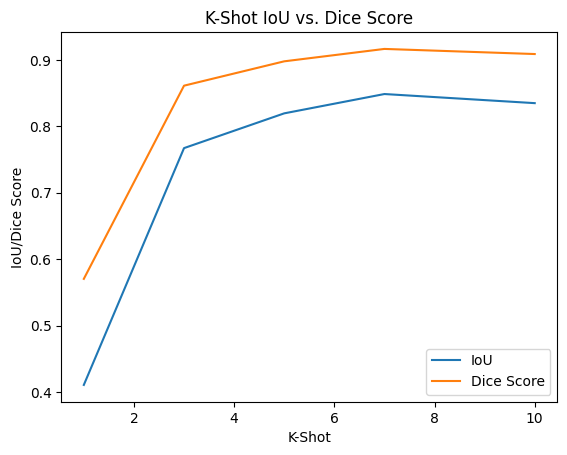

In [62]:
plt.plot([1, 3, 5, 7, 10], few_iou)
plt.plot([1, 3, 5, 7, 10], few_dice)
plt.xlabel("K-Shot")
plt.ylabel("IoU/Dice Score")
plt.title("K-Shot IoU vs. Dice Score")
plt.legend(["IoU", "Dice Score"])

## Explainability

In [63]:
shot = SHOT # Change to compare to pretrained checkpoints
model = torch.load(f'{SAVE_DIR}/best_model_{shot}_shot.pth', map_location=torch.device(DEVICE))

In [64]:
class GradCamSampler(nn.Module):
    def __init__(self, img_root, mask_root, image_files, mask_files, transforms=None, preprocessing=None, samples_to_generate=5):
        self.img_root = img_root
        self.mask_root = mask_root
        self.img_files = image_files
        self.mask_files = mask_files
        self.samples_to_generate = samples_to_generate
        self.transforms = transforms
        self.preprocessing = preprocessing

    def _sample_images_for_gradcam(self):
        sample_ids = np.random.choice(range(len(self.img_files)), size=self.samples_to_generate)
        self.ids = sample_ids

    def __len__(self):
        return self.samples_to_generate

    def __getitem__(self, idx):
        image = np.array(Image.open(os.path.join(self.img_root, self.img_files[idx])))
        mask = np.array(Image.open(os.path.join(self.mask_root, self.mask_files[idx])))

        # image = np.stack([image, image, image], axis=-1)

        if self.transforms is not None:
            transformed = self.transforms(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
        # mask = torch.unsqueeze(mask, 0)

        if self.preprocessing is not None:
            transformed = self.preprocessing(image=image)
            image = transformed["image"]
            # mask = transformed["mask"]

        return image.type(torch.FloatTensor), mask/255.0

In [70]:
augmentations = A.Compose([A.Resize(256, 256), ToTensorV2()])

test_set = GradCamSampler(os.path.join(FEW_SHOT_ROOT, "test/images"),
                                         os.path.join(FEW_SHOT_ROOT, "test/labels"),
                                         test.images, test.masks,
                                         preprocessing=None,#get_preprocessing(preprocessing_fn),
                                         transforms=test_augmentations)

In [71]:
test_loader = DataLoader(test_set, batch_size=1, shuffle=False, num_workers=2)
test_img, test_mask  = next(iter(test_loader))

In [72]:
class SemanticSegmentationTarget:
    def __init__(self, category, mask):
        self.category = category
        if type(mask) == np.array:
            self.mask = torch.from_numpy(mask)
        else:
            self.mask = mask

        if torch.cuda.is_available():
            self.mask = self.mask.cuda()

    def __call__(self, model_output):
        print(self.mask.shape == model_output.shape)
        return (model_output[self.category,:,:] * self.mask).sum()


True
True
True
True
True


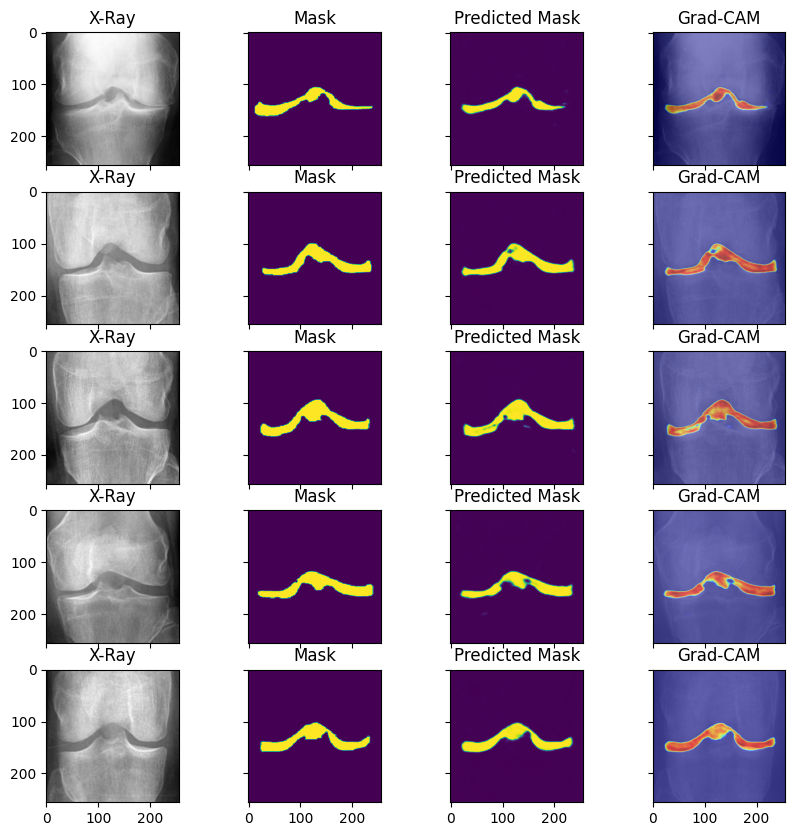

In [73]:
target_layers = [model.decoder, model.segmentation_head]
iou = smp_utils.metrics.IoU(threshold=0.5)

with GradCAM(model=model,
             target_layers=target_layers,
             use_cuda=torch.cuda.is_available()) as cam:

    fig, ax = plt.subplots(len(test_loader), 4, figsize=(10, 10), sharex=True, sharey=True)

    for i, (test_img, test_mask) in enumerate(test_loader):
        targets = [SemanticSegmentationTarget(0, test_mask)]

        grayscale_cam = cam(input_tensor=test_img,
                            targets=targets)[0, :]

        test_img2= test_img.squeeze().squeeze().detach().cpu().numpy()/255.0
        test_img2 = np.stack([test_img2, test_img2, test_img2], axis=-1)

        cam_image = show_cam_on_image(test_img2, grayscale_cam, use_rgb=True)
        out = model(test_img.to(DEVICE))

        ax[i, 0].imshow(test_img[0][0,:,:].squeeze(),cmap="gray")
        ax[i, 0].set_title("X-Ray")
        ax[i, 1].imshow(test_mask.squeeze())
        ax[i, 1].set_title("Mask")
        ax[i, 2].imshow(torch.sigmoid(out).squeeze().detach().cpu().numpy())
        ax[i, 2].set_title("Predicted Mask")
        ax[i, 3].imshow(Image.fromarray(cam_image))
        ax[i, 3].set_title("Grad-CAM")